模型在训练cuda:0上训练


 10%|█         | 102/1000 [00:08<01:12, 12.31it/s]

第100轮训练 ==> 训练损失:  1.08336 	 测试损失:  2.45488


 20%|██        | 202/1000 [00:16<01:03, 12.48it/s]

第200轮训练 ==> 训练损失:  0.63746 	 测试损失:  2.93847


 30%|███       | 302/1000 [00:24<00:55, 12.54it/s]

第300轮训练 ==> 训练损失:  0.53458 	 测试损失:  3.93154


 40%|████      | 402/1000 [00:32<00:46, 12.84it/s]

第400轮训练 ==> 训练损失:  0.43464 	 测试损失:  2.99142


 50%|█████     | 502/1000 [00:40<00:38, 12.99it/s]

第500轮训练 ==> 训练损失:  0.43126 	 测试损失:  2.64165


 60%|██████    | 602/1000 [00:47<00:30, 12.95it/s]

第600轮训练 ==> 训练损失:  0.35657 	 测试损失:  1.79701


 70%|███████   | 702/1000 [00:55<00:23, 12.91it/s]

第700轮训练 ==> 训练损失:  0.40219 	 测试损失:  1.96348


 80%|████████  | 802/1000 [01:03<00:15, 12.93it/s]

第800轮训练 ==> 训练损失:  0.31457 	 测试损失:  1.71826


 90%|█████████ | 902/1000 [01:11<00:07, 12.89it/s]

第900轮训练 ==> 训练损失:  0.30112 	 测试损失:  1.59837


100%|██████████| 1000/1000 [01:18<00:00, 12.71it/s]


第1000轮训练 ==> 训练损失:  0.27594 	 测试损失:  1.74599


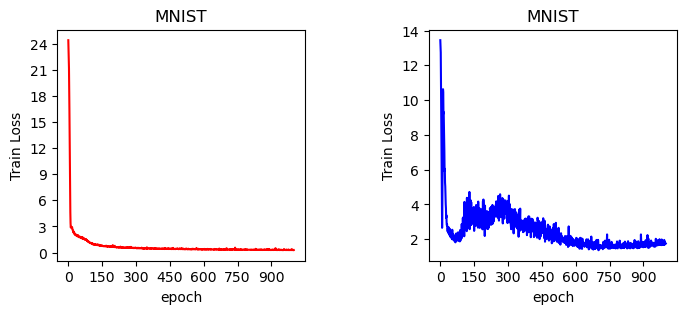

In [33]:
import random
import torch.utils
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from matplotlib import ticker

import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd


torch.cuda.manual_seed(43)
torch.manual_seed(43)
random.seed(43)

def load_dataset():
    dataset = pd.read_csv("../dataset/boston/HousingData.csv")

    columns = list(dataset.columns)
    for i in range(len(columns) - 1):
        col_name = columns[i]
        dataset.fillna(dataset[col_name].mean(), inplace=True)


    X = dataset.values[:, :-1]
    Y = dataset.values[:, -1].reshape(506, -1)

    num = X.shape[0]

    train_X = X[:int(num * 0.6), :]
    test_X = X[int(num * 0.6):, :]
    train_Y = Y[:int(num * 0.6), :]
    test_Y = Y[int(num * 0.6):, :]

    return train_X, train_Y, test_X, test_Y

class WrapperDataset(Dataset):
    def __init__(self, data_x, data_y):
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y
    
    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        return torch.Tensor(x), torch.Tensor(y)
    
    def __len__(self):
        return len(self.data_x)

train_X, train_Y, test_X, test_Y = load_dataset()
dataset_train = WrapperDataset(train_X, train_Y)
dataset_test = WrapperDataset(test_X, test_Y)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(13, 10),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(10, 5),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(5, 5),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(5, 1)
        )
    
    def forward(self, x):
        return self.model(x)


def model_eval(data_iter, device, loss):
    model.eval()
    total_loss = 0.0
    total_num = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_iter):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            l = loss(output, labels)
            
            total_loss += l.item()
            total_num += labels.shape[0]
    return total_loss / total_num

def train(model, train_loader, test_loader, optimizer, loss, epoches, device):
    train_accuracy_array = []
    test_accuracy_array = []
    for epoch in tqdm(range(epoches)):
        losses, nums = 0.0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            l = loss(output, y)

            losses += l.item()
            nums += y.shape[0]

            # Update net params
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        
        train_loss = model_eval(train_loader, device, loss)
        test_loss = model_eval(test_loader, device, loss)
        train_accuracy_array.append(train_loss)
        test_accuracy_array.append(test_loss)
        if (epoch + 1) % 100 == 0:
            print(f"第{epoch + 1}轮训练 ==> 训练损失: {train_loss: .5f} \t 测试损失: {test_loss: .5f}")
    
    return train_accuracy_array, test_accuracy_array

device = "cuda:0" if torch.cuda.is_available else "cpu"
model = MLP().to(device)
epoches = 1000
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr)
loss = torch.nn.MSELoss()

print(f"模型在训练{device}上训练")

train_loss_array, test_loss_array = train(model, train_loader, test_loader, optimizer, loss, epoches, device)

_, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(range(len(train_loss_array)), train_loss_array, c='r') 
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("MNIST")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(range(len(test_loss_array)), test_loss_array, c='b')
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("Train Loss")
axes[1].set_title("MNIST")
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.subplots_adjust(wspace=0.5)
plt.show()